In [1]:
import numpy as np

full_data = np.load('./full_data.npy', allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

In [2]:
import tensorflow as tf
from tensorflow import keras

2022-02-08 16:30:25.047278: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# GPU memory management

all_devices = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", all_devices)
physical_devices=tf.config.experimental.list_physical_devices('GPU')
gpus= tf.config.experimental.list_physical_devices('GPU')
for i in range(0,all_devices):
    tf.config.experimental.set_memory_growth(gpus[i], True)

mirrored_strategy = tf.distribute.MirroredStrategy(devices=[f"/GPU:{GPU_id}" for GPU_id in range (0,6)])

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')


2022-02-04 10:04:04.416014: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-04 10:04:04.419506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-04 10:04:05.046659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-04 10:04:05.046688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-04 10:04:05.056405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-04 10:04:05.056431: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

In [11]:
# Build NN
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten, AlphaDropout
from tensorflow.keras.models import Model, Sequential


# RNN part
obj_input = Input(shape=X_train_obj.shape[1:])
lstm1 = LSTM(100)(obj_input)
# lstm_output = Dense(1, activation="sigmoid")(lstm1)

event_input = Input(shape=X_train_event.shape[1])
x = Concatenate()([lstm1, event_input])
# Feedforward part
hidden1 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(x)
do1 = AlphaDropout(rate=0.2)(hidden1)
hidden2 = Dense(200, activation='selu', kernel_initializer='lecun_normal')(do1)
do2 = AlphaDropout(rate=0.2)(hidden2)
hidden3 = Dense(200, activation='selu', kernel_initializer='lecun_normal')(do2)
do3 = AlphaDropout(rate=0.2)(hidden3)
out = Dense(1, activation="sigmoid")(do3)
# event_output = Dense(1, activation='sigmoid')(hidden3)
# out_combined = Concatenate()([lstm_output, event_output])
# out = Dense(1, activation="sigmoid")(out_combined)
combined_model = Model(inputs=[obj_input, event_input], outputs=out)
combined_model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy()])
print(combined_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14, 7)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100)          43200       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 111)          0           lstm_2[0][0]                     
                                                                 input_6[0][0]              

In [12]:
# Imbalanced dataset so want to adjusts weights of signal and background training examples
tot = len(y_train)
pos = np.sum(y_train['ttH125'])
neg = tot - pos
print(f'Total training samples:  {tot}\npositives:  {pos}\nnegatives:  {neg}')

# weight positives more than negatives
weight_for_0 = (1 / neg) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Postive weight:  {weight_for_1} \nNegative weight:  {weight_for_0}')

Total training samples:  327177
positives:  79444
negatives:  247733
Postive weight:  2.0591674638739237 
Negative weight:  0.660341981084474


In [13]:
history = combined_model.fit([X_train_obj, X_train_event], y_train['ttH125'], epochs=20, batch_size=64, class_weight=class_weight, 
validation_data=([X_test_obj, X_test_event], y_test['ttH125']))

Epoch 1/20
5113/5113 [==============================] - 41s 7ms/step - loss: 0.5783 - auc_2: 0.7725 - precision_2: 0.4298 - recall_2: 0.7149 - binary_accuracy: 0.6997 - val_loss: 0.5865 - val_auc_2: 0.8192 - val_precision_2: 0.4894 - val_recall_2: 0.7308 - val_binary_accuracy: 0.7495
Epoch 2/20
5113/5113 [==============================] - 34s 7ms/step - loss: 0.5311 - auc_2: 0.8116 - precision_2: 0.4753 - recall_2: 0.7329 - binary_accuracy: 0.7382 - val_loss: 0.5133 - val_auc_2: 0.8251 - val_precision_2: 0.5387 - val_recall_2: 0.6806 - val_binary_accuracy: 0.7809
Epoch 3/20
5113/5113 [==============================] - 29s 6ms/step - loss: 0.5234 - auc_2: 0.8177 - precision_2: 0.4864 - recall_2: 0.7309 - binary_accuracy: 0.7469 - val_loss: 0.6585 - val_auc_2: 0.8285 - val_precision_2: 0.5145 - val_recall_2: 0.7225 - val_binary_accuracy: 0.7671
Epoch 4/20
5113/5113 [==============================] - 36s 7ms/step - loss: 0.5173 - auc_2: 0.8223 - precision_2: 0.4925 - recall_2: 0.7319 - bi

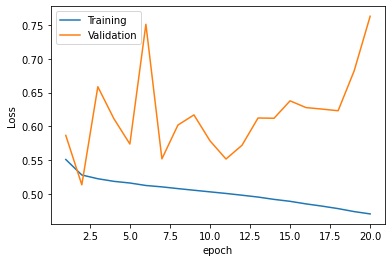

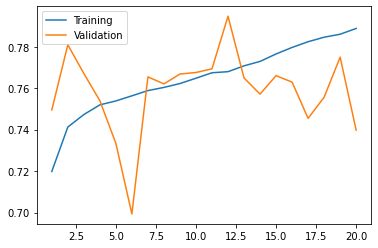

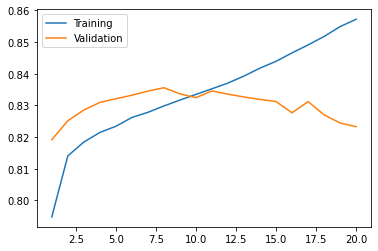

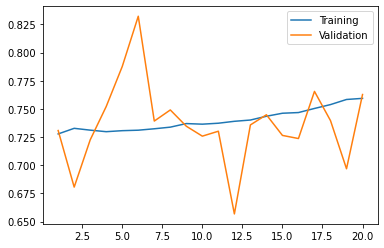

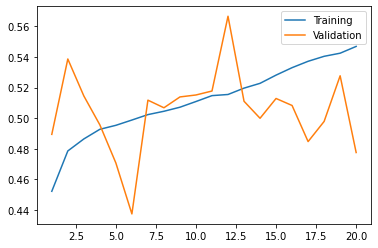

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(1,21), history.history['loss'], label='Training')
plt.plot(range(1,21), history.history['val_loss'], label='Validation')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(range(1, 21), history.history['binary_accuracy'], label='Training')
plt.plot(range(1, 21), history.history['val_binary_accuracy'], label='Validation')
plt.legend()
plt.show()

plt.plot(range(1, 21), history.history['auc_2'], label='Training')
plt.plot(range(1, 21), history.history['val_auc_2'], label='Validation')
plt.legend()
plt.show()

plt.plot(range(1, 21), history.history['recall_2'], label='Training')
plt.plot(range(1, 21), history.history['val_recall_2'], label='Validation')
plt.legend()
plt.show()

plt.plot(range(1, 21), history.history['precision_2'], label='Training')
plt.plot(range(1, 21), history.history['val_precision_2'], label='Validation')
plt.legend()
plt.show()

In [3]:
# combined_model = keras.models.load_model("./RNN_model")

2022-02-08 16:31:12.847429: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-08 16:31:12.849045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-08 16:31:13.794684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-08 16:31:13.797314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-08 16:31:13.799809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:5f:00.0 name: Tesla T4 computeCapability: 

In [23]:
# Model predictions

y_pred = combined_model.predict([X_test_obj, X_test_event])
y_train_pred = combined_model.predict([X_train_obj, X_train_event])


In [25]:
y_train['Predictions'] = y_train_pred
y_train

,TTTo2L2Nu,TTToHadronic,TTToSemiLeptonic,ttH125,Predictions
99106,0,0,0,1,0.644411
238745,0,0,1,0,0.013470
23035,0,0,0,1,0.301922
97258,0,0,0,1,0.725907
330236,0,0,1,0,0.391237
...,...,...,...,...,...
395801,1,0,0,0,0.530412
276039,0,0,1,0,0.482761
25531,0,0,0,1,0.990072
294188,0,0,1,0,0.485392


<BarContainer object of 3 artists>

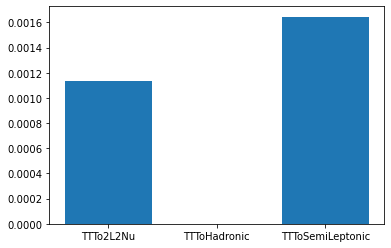

In [32]:
import matplotlib.pyplot as plt

thr = 0.99
plt.bar(y_train.columns[:-2], [len(y_train[(y_train[column]==1) & (y_train["Predictions"] >= thr)])/y_train[column].sum() for column in y_train.columns[:-2]])

<BarContainer object of 3 artists>

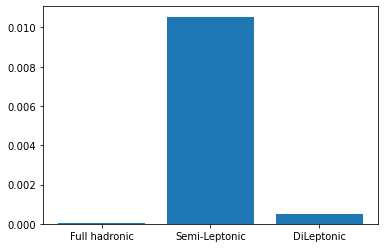

In [17]:
plt.bar(["Full hadronic", "Semi-Leptonic", "DiLeptonic"], [fh/len(y_train), sl/len(y_train), dl/len(y_train)], label="Overall")


In [33]:
threshold = 0.9
wrongs = X_train_event[(y_train_pred >= threshold) & (y_train == 0)]


In [34]:
X_train_event.shape

(327177, 11)

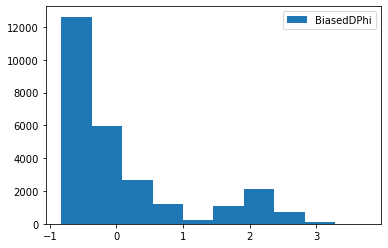

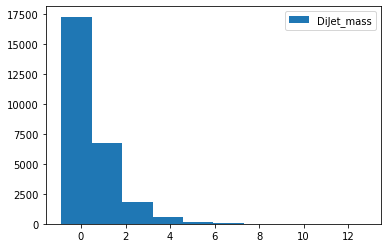

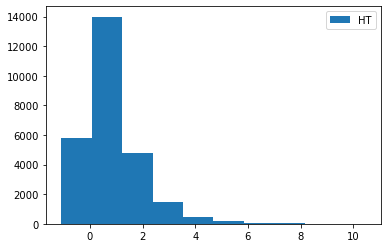

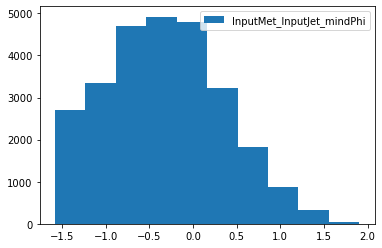

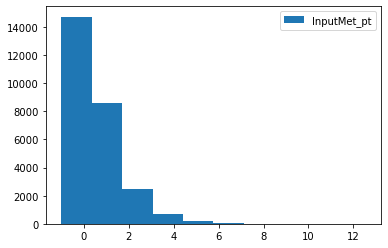

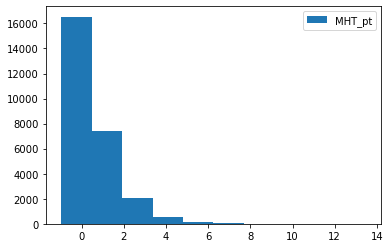

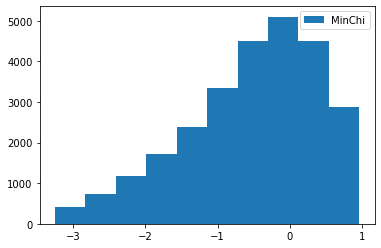

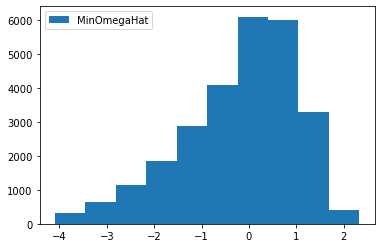

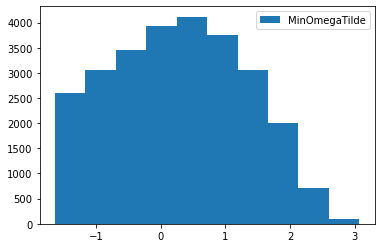

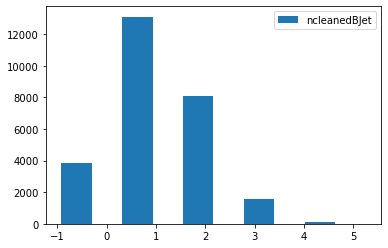

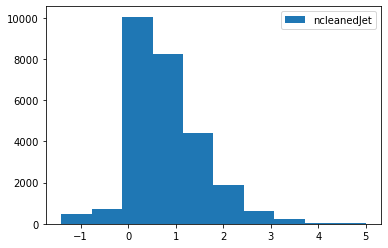

In [36]:
columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi', 'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'ncleanedBJet', 'ncleanedJet']
for idx, column in enumerate(columns):
    plt.hist(wrongs[:,idx], label=columns[idx])
    plt.legend()
    plt.show()

In [37]:
# Analysis

thresholds = np.arange(0, 1.001, 0.001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))

y_test['Predictions'] = y_pred

for idx, threshold in enumerate(thresholds):
    # FP[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred >= threshold)).sum()
    # FN[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred < threshold)).sum()
    # TP[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred >= threshold)).sum()
    # TN[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred < threshold)).sum()
    FP[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] >= threshold)])
    FN[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] < threshold)])
    TP[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] >= threshold)])
    TN[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] < threshold)])

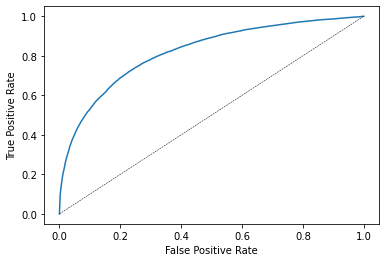

In [39]:
import matplotlib.pyplot as plt

# ROC curve
tpr = TP/(np.sum(y_test['ttH125']))
fpr = FP/(len(y_test[y_test['ttH125']==0]))
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', linewidth=0.5, color='k')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.savefig("./RNN_02/02/ROC.png", dpi=300)
plt.show()

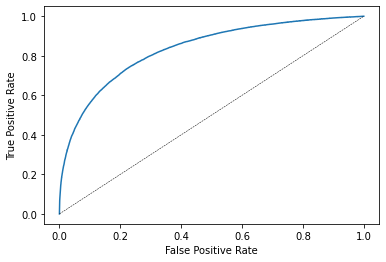

In [18]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve (y_test , y_pred)
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', linewidth=0.5, color='k')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.savefig("first_RNN_stuff/tuned_RNN_60_epochs/ROC.png", dpi=300)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

auc_score=roc_auc_score(y_test['ttH125'], y_test['Predictions'])
auc_score

0.8200913526976124

In [43]:
# Significance

# load xs weights
train_weights, test_weights = np.load('weights.npy', allow_pickle=True)

# Get predictions for combined dataset
# y_pred_train = combined_model.predict([X_train_obj, X_train_event])
# y_total = np.concatenate([y_train, y_test])
# y_pred_train = y_pred_train.reshape(y_train.shape)
# y_pred_total = np.concatenate([y_pred_train, y_pred])

In [10]:
total_weights = np.concatenate([train_weights, test_weights])

In [11]:
set(total_weights[y_total==1])

{-8.6958615e-08, 8.6958615e-08}

In [8]:
significance = np.zeros(len(thresholds), dtype=float)
lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.05

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 1)).astype(int)).sum()
    bg[idx] = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance[idx] = sg[idx]/np.sqrt(bg[idx] + (sigma * bg[idx])**2)
    else:
        end_idx = idx
    # print(f"Signal events surviving cut:  {sg[idx]}\nBackground events surviving cut:  {bg[idx]}\nCorresponding siginificance is:  {significance[idx]}")

NameError: name 'total_weights' is not defined

In [44]:
significance = np.zeros(len(thresholds), dtype=float)
lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.1

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * test_weights * 5 * ((y_test >= threshold) & (y_test == 1)).astype(int)).sum()
    bg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (y_test == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance[idx] = sg[idx]/np.sqrt(bg[idx] + (sigma * bg[idx])**2)
    else:
        end_idx = idx
    # print(f"Signal events surviving cut:  {sg[idx]}\nBackground events surviving cut:  {bg[idx]}\nCorresponding siginificance is:  {significance[idx]}")

ValueError: setting an array element with a sequence.

In [33]:
bg

array([4.51478412e+04, 4.39195529e+04, 4.19153791e+04, ...,
       9.37885944e+02, 6.93414328e+02, 1.17277007e+01])

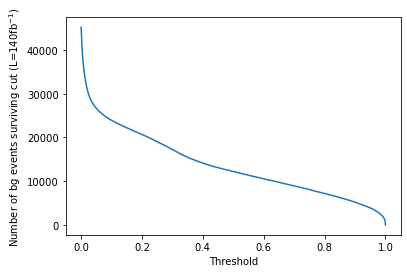

In [14]:
import matplotlib.pyplot as plt

plt.plot(thresholds, bg)
# plt.plot(thresholds, np.sqrt(bg), label="sqrt backgrounds")
plt.xlabel("Threshold")
plt.ylabel(r"Number of bg events surviving cut (L=140fb$^{-1}$)")
# plt.savefig("./RNN_02/02/bg_events_test_set.png")
plt.show()

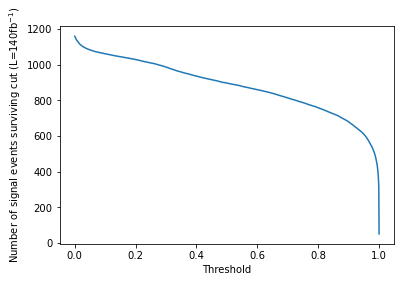

In [15]:
plt.plot(thresholds, sg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of signal events surviving cut (L=140fb$^{-1}$)")
# plt.savefig("./RNN_02/02/sg_events_test_set.png")
plt.show()

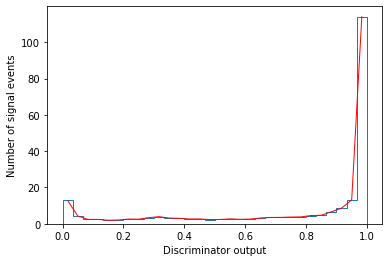

In [14]:
# signal
hist, bins, patches = plt.hist(y_pred[y_test==1], weights=lum*test_weights[y_test==1], bins=30, histtype="step")
plt.xlabel("Discriminator output")
plt.ylabel("Number of signal events")
plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, color="r", linewidth=1)
plt.show()

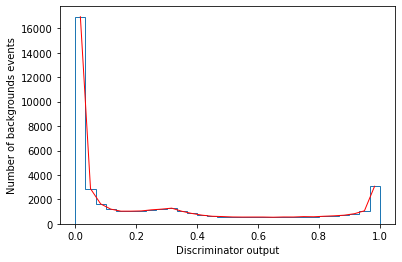

In [51]:
# Background

hist_, bins, patches = plt.hist(y_pred_total[y_total==0], weights=lum*total_weights[y_total==0], bins=bins, histtype="step")
plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, color="r", linewidth=1)
plt.xlabel("Discriminator output")
plt.ylabel("Number of backgrounds events")
plt.show()

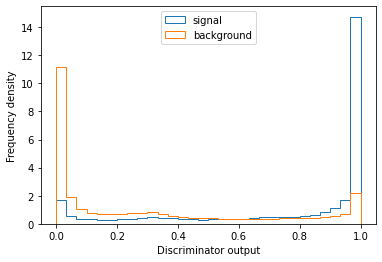

In [16]:
hist, bins, patches = plt.hist(y_pred[y_test==1], weights=lum*test_weights[y_test==1], bins=30, density=True, histtype='step', label="signal")
hist_, bins, patches = plt.hist(y_pred[y_test==0], weights=lum*test_weights[y_test==0], bins=bins, density=True, histtype='step', label="background")
plt.xlabel("Discriminator output")
plt.ylabel("Frequency density")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, linewidth=1.2, label="signal")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, linewidth=1.2, label="background")
plt.legend(loc="upper center")
# plt.savefig("./RNN_02/02/Discriminator_test_set.png", dpi=300)
plt.show()

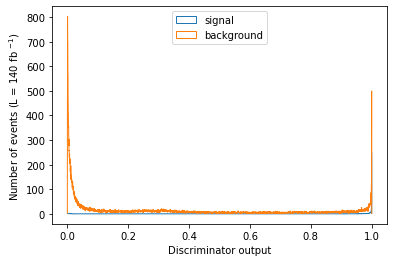

In [18]:
import matplotlib.pyplot as plt

lum = 140e3

hist, bins, patches = plt.hist(y_pred[y_test==1], weights=5*lum*test_weights[y_test==1], bins=3000, histtype='step', label="signal")
hist_, bins, patches = plt.hist(y_pred[y_test==0], weights=5*lum*test_weights[y_test==0], bins=bins, histtype='step', label="background")
plt.xlabel("Discriminator output")
plt.ylabel(r"Number of events (L = 140 fb $^{-1}$) ")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, linewidth=1.2, label="signal")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, linewidth=1.2, label="background")
plt.legend(loc="upper center")
# plt.savefig("./RNN_02/02/Discriminator_test_set_event_number.png", dpi=300)
plt.show()

Text(0.5, 0, 'Discriminator output')

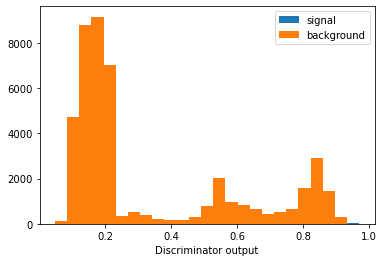

In [149]:
hist, bins, patches = plt.hist(y_pred_total[y_total==1], weights=lum*total_weights[y_total==1], bins=25, label="signal")
plt.hist(y_pred_total[y_total==0], weights=lum*total_weights[y_total==0], bins=bins, label="background")
plt.legend()
plt.xlabel("Discriminator output")

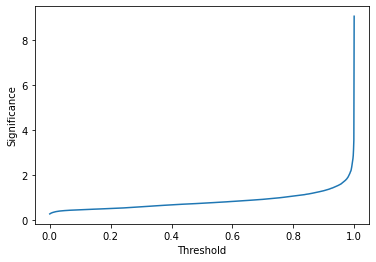

In [13]:
import matplotlib.pyplot as plt

plt.plot(thresholds, significance)
# plt.vlines(thresholds[np.argmax(significance)], linestyles="dashed", color='k', ymin=0, ymax=np.max(significance), linewidth=0.8,
#     label=f"Best threshold = {round(thresholds[np.argmax(significance[:end_idx])], 2)}")
# plt.hlines(np.max(significance), linestyles="dashed", color="k", xmin=0, xmax=1.0, linewidth=0.8)
plt.xlabel("Threshold")
plt.ylabel("Significance")

# plt.savefig("RNN_02/02/significance_test_set.png", dpi=300)
# plt.legend(loc="lower left")
plt.show()

In [19]:
print(significance[-10:])
print(sg[-1])
print(bg[-1])

[2.26973627 2.34618705 2.43126286 2.50211453 2.602397   2.71559348
 2.85488112 3.12900317 3.54903161 9.05328939]
51.009920969605446
25.3303040266037


In [143]:
np.sum(140e3 * total_weights * y_total)/np.sqrt(np.sum(140e3 * total_weights * (y_total==0)))

5.470651

In [142]:
np.sum(total_weights * (y_total==0))

0.32248455

In [20]:
print(f"Best threshold is {thresholds[np.argmax(significance)]}")

Best threshold is 1.0


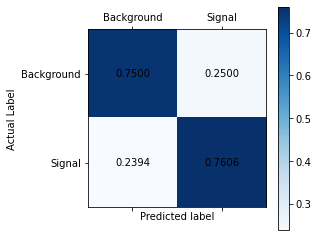

In [24]:
idx = np.argmin(abs(fpr-0.25))

conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
plt.matshow(conf_mat, cmap='Blues')
for (x, y), value in np.ndenumerate(conf_mat):
    plt.text(y, x, f"{value:.4f}", va="center", ha="center")
plt.xlabel('Predicted label')
plt.ylabel('Actual Label')
plt.xticks([0,1], labels=['Background', 'Signal'])
plt.yticks([0,1], labels=['Background', 'Signal'])
plt.colorbar()
# plt.savefig("./RNN_02/02/conf_matrix_max_sig.png", dpi=300)
plt.show()

In [26]:
combined_model.save("./first_RNN_stuff/tunded_RNN_60_epochs")

INFO:tensorflow:Assets written to: ./first_RNN_stuff/tunded_RNN_60_epochs/assets


INFO:tensorflow:Assets written to: ./first_RNN_stuff/tunded_RNN_60_epochs/assets


In [46]:
threshold = thresholds[idx]

sg = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 1))).sum()
bg = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 0))).sum()
significance[idx] = sg/np.sqrt(bg)
print(f"Signal events surviving cut:  {sg}\nBackground events surviving cut:  {bg}\nCorresponding siginificance is:  {significance[idx]}")

Signal events surviving cut:  46.3593864440918
Background events surviving cut:  11.727702140808105
Corresponding siginificance is:  13.537274360656738


0.0